In [47]:
"""
POMDP Gaussian processes abstraction (basic)
Given
    -  x^+= A x + Bu + w , w ~ N(0,W)
    -  z = Cx+Fv
Do :
    - Quantify eps,
    - Abstract to finite MDP
    Remark that since there is no order reduction,
     there is also no delta error.

Author Sofie Haesaert
Date = 13 December 2017
"""


'\nPOMDP Gaussian processes abstraction (basic)\nGiven\n    -  x^+= A x + Bu + w , w ~ N(0,W)\n    -  z = Cx+Fv\nDo :\n    - Quantify eps,\n    - Abstract to finite MDP\n    Remark that since there is no order reduction,\n     there is also no delta error.\n\nAuthor Sofie Haesaert\nDate = 13 December 2017\n'

In [48]:

from ApprxSimulation.LTI_simrel import tune_dratio
from ApprxSimulation.Visualize import plot_regions, patch_ellips, ellips_cov
from Models.MDP import Rpol
from label_abstraction.test_mdp import test_mdp_dfsa, formula_to_mdp, test_ltl_synth2
# Import packages:
from Models.Linear import LTI, POMDP
from label_abstraction.mdp import *
import matplotlib.pyplot as plt
import polytope as pc
import numpy.linalg as LA


print('Imported packages')


Imported packages


In [49]:


print('Initialise system values')
# Define the linear time invariant system
#A = np.array([[0,-0.8572],[0.1,0.5]])
dim = 2
A = np.array([[.9,-0.32],[0.1,0.9]])
B = np.eye(dim)  #array([[1], [0.1]])
W = np.array([[.4,-0.2],[-0.2,0.4]])  # noise on state transitions
 
# Accuracy
C = np.array([[1, 0],[0,1]])  # defines metric for error (||y_finite-y||< epsilon with y= cx   )

sys_lti = LTI(A, B, C, None, W=W)  # LTI system with   D = None


Initialise system values


In [50]:
print('Initialise sensor model')

# Sensor noise => pomdp
H = np.array([[1, -1]])  #np.ones((1,2)) # what can be measured
V = 1*np.eye(1)
    #  x^+= A x + Bu + w
    #  y = C x
    #  z = H x+v

P = np.eye(2)
mean = np.zeros((2,1))

pomdp = POMDP(sys_lti, H, V, P, mean)


Initialise sensor model


(10.0, 2.0, 10.0, 10.0, 2.0, 10.0, 2.0, 2.0)


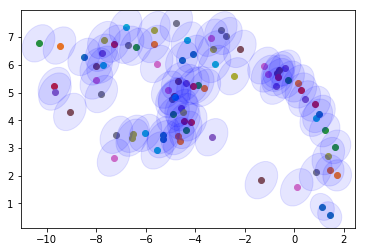

In [51]:



L, Pst = pomdp.kalman()

belief_mdp = pomdp.beliefmodel()

fig = plt.figure()
ax = fig.add_subplot(111)
print(tuple(x.flatten()))
for trace in range(2):
    belief_mdp.state =  (np.array([[0],[0]]).reshape(-1,1), 0*np.eye(2))
    for i in range(40):
        (x,P) = belief_mdp.simulate(np.array([[1],[1]]))
        ellips_cov(P, 1, ax, pos =  tuple(x.flatten()))
        plt.scatter(x[0],x[1])

plt.axis('tight')
plt.show()

In [52]:
# to steady state

lti_pomdp = belief_mdp.to_LTI(C)

In [53]:


# Define spaces
lti_pomdp.setU(pc.box2poly(np.kron(np.ones((sys_lti.m, 1)), np.array([[-3, 3]])))) # continuous set of inputs
lti_pomdp.setX(pc.box2poly(np.kron(np.ones((sys_lti.dim, 1)), np.array([[-10, 10]])))) # X space


# Define regions of interest for the labeling
regions = dict()
regions['target'] = pc.box2poly(np.kron(np.ones((2, 1)), np.array([[2, 10]])))
# add avoid
regions['avoid'] = pc.box2poly(np.array([[-5, 3],[-10, 5]]))

x =pc.extreme(regions['target'])
 
y =pc.extreme(regions['avoid'])


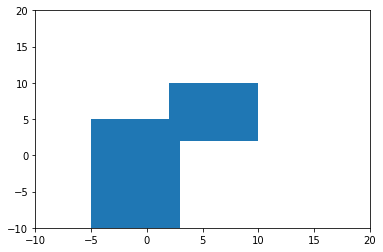

In [54]:
import matplotlib.patches
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
patch = matplotlib.patches.Polygon(x)
ax.add_patch(patch)

patch = matplotlib.patches.Polygon(y)
ax.add_patch(patch)

plt.xlim([-10,20])
plt.ylim([-10,20])

plt.show()

1.  Transform to normalised state space
[[ -5.38203   0.4532    5.92587   0.09064]
 [  8.6622   14.13487   8.29964   2.82697]]


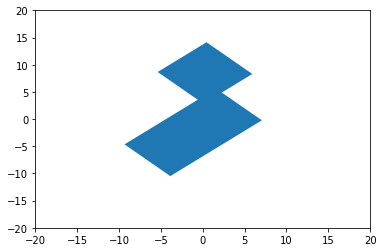

In [55]:
import numpy.linalg as LA
fig = plt.figure()
ax = fig.add_subplot(111)

sys_n = lti_pomdp.normalize()
print('1.  Transform to normalised state space')
x = pc.extreme(regions['target'])
y = pc.extreme(regions['avoid'])

xtr = LA.inv(sys_n.T2x).dot(x.T)
print(xtr)
patch = matplotlib.patches.Polygon(xtr.T)
ax.add_patch(patch)
# 
patch = matplotlib.patches.Polygon(LA.inv(sys_n.T2x).dot(y.T).T)
ax.add_patch(patch)

plt.xlim([-20,20])
plt.ylim([-20,20])

plt.show()


2.  Tune gridding ratio


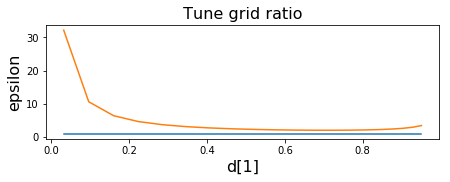

('Choose grid ribs as', array([[ 0.83153],
       [ 0.8652 ]]))


In [89]:

## step 1: tune gridding ratio (find optimal horizontal d_1, and vertical d_2)
# currently only available for 2D
print('2.  Tune gridding ratio')
d_opt, d_vals, eps_values = tune_dratio(sys_n)
# d_opt has optimal ratio with grid diameter of 1
# choose grid sizes (factor of d_opt)
d = d_opt*1.2 #  with distance measure
print('Choose grid ribs as', d)    # *Grid space


3.  Grid Gaussian process
[[ 0.63643  0.     ]
 [ 0.       0.     ]]
[[-0.68408  0.7294 ]
 [ 0.7294   0.68408]]
Warning no inputspace given
Warning no state space given


status: optimal
optimal epsilon 1.20604537593
optimal M [[ 1.  0.]
 [ 0.  1.]]
Optimal K [[ 0.84908 -0.43756]
 [-0.58805 -0.68862]]


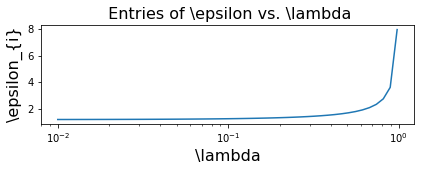

((1191, 49), (49, 1191, 1191))
--- done gridding


In [93]:


print('3.  Grid Gaussian process')

print(sys_n.W)
print(sys_n.T2x)
mdp_grid = sys_n.abstract_io(d, un=7, verbose=False)  # do the gridding
print('--- done gridding')


In [84]:



print('4.  Define formula and compute DFA')

#formula = '( ( ! avoid U target ) & ( F avoid ) )'
formula = '( ( avoid ) & F target )'

# figure out a map dict_input2prop from numeric inputs to name based inputs
dfsa, init, final, dict_input2prop = formula_to_mdp(formula)

mdp_grid.map_dfa_inputs(dict_input2prop, regions)
mdp_grid.setdfa(dfsa,final)


4.  Define formula and compute DFA
& avoid F target
['avoid', 'target']
{0: (), 1: ('avoid',), 2: ('target',), 3: ('avoid', 'target')}
set([1])
('check norm of rows', matrix([[ 0.68408,  0.7294 ],
        [-0.7294 ,  0.68408],
        [-0.68408, -0.7294 ],
        [ 0.7294 , -0.68408]]))
('check norm of rows', matrix([[ 0.68408,  0.7294 ],
        [-0.7294 ,  0.68408],
        [-0.68408, -0.7294 ],
        [ 0.7294 , -0.68408]]))


In [85]:

print('5. Compute recursions')

mdp_grid.policy= None
mdp_grid.trans_qs = None
V, policy, W = mdp_grid.reach_dfa(recursions = 3)


5. Compute recursions


In [86]:
pol = None
pol = Rpol(mdp_grid, V, W, policy)

pol.set_regions(dict_input2prop, regions)


In [87]:
print('6. Plot normalized systen')
fig = plt.figure()

xi, yi = np.meshgrid(*mdp_grid.srep)

plt.pcolor(mdp_grid.sedge[0], mdp_grid.sedge[1],  W[:-1].reshape(xi.shape, order='F'))
plt.colorbar()
plt.xlim(np.array([mdp_grid.srep[0][0],mdp_grid.srep[0][-1]]))
plt.ylim(np.array([mdp_grid.srep[1][0],mdp_grid.srep[1][-1]]))
#plt.show()

xi, yi = np.meshgrid(np.linspace(mdp_grid.srep[0][0],mdp_grid.srep[0][-1],10),
                     np.linspace(mdp_grid.srep[1][0],mdp_grid.srep[1][-1],10))

#compute inputs
# u =sys_n.b.dot(pol.cst(np.block([[xi.flatten()],[yi.flatten()]]) ))
# delx = (-np.block([[xi.flatten()],[yi.flatten()]])
#         +sys_n.a.dot(np.block([[xi.flatten()],[yi.flatten()]])) 
#         + sys_n.b.dot(pol.cst(np.block([[xi.flatten()],[yi.flatten()]]))))
# x_tr = (np.block([[xi.flatten()], [yi.flatten()]]))

#plt.quiver(xi.flatten(), yi.flatten(),u[0],u[1])
# plt.quiver(x_tr[0],x_tr[1],delx[0],delx[1], color = 'r')


6. Plot normalized systen


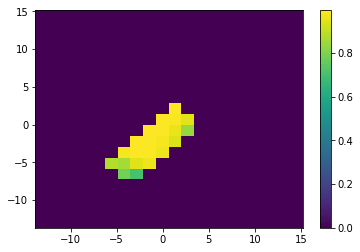

In [88]:

plt.show()


6. Plot concrete systen


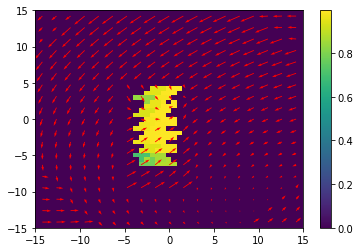

In [72]:
print('6. Plot concrete systen')
fig = plt.figure()
x_edge = np.linspace(-15,15,50)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,50)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)

values = pol.val_concrete(np.block([[xi.flatten()], [yi.flatten()]]))
plt.pcolor(x_edge, y_edge, values.reshape(xi.shape))
plt.colorbar()
plt.xlim(np.array([-15,15]))
plt.ylim(np.array([-15,15]))

x_edge = np.linspace(-15,15,20)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,20)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)

u =sys_lti.b.dot(pol.cst(np.block([[xi.flatten()],[yi.flatten()]]),transformed = False))
delx = (-np.block([[xi.flatten()],[yi.flatten()]])
        +sys_lti.a.dot(np.block([[xi.flatten()],[yi.flatten()]])) 
        + sys_lti.b.dot(pol.cst(np.block([[xi.flatten()],[yi.flatten()]]),transformed = False)))
x_tr = (np.block([[xi.flatten()], [yi.flatten()]]))

#plt.quiver(xi.flatten(), yi.flatten(),u[0],u[1])
plt.quiver(x_tr[0],x_tr[1],delx[0],delx[1], color = 'r')

plt.show(fig)

In [95]:
# how to get a nice simulation? 
from random import  gauss 
import random
import scipy.linalg as scla
random.seed(a = '4')
print('final state:', final)
time = 50
noise = scla.sqrtm( lti_pomdp.W)
fig = plt.figure()
ax = fig.add_subplot(111)
for x0 in (np.array([[0],[0]]),np.array([[0],[4]])):
    for repeating in range(10):
        pol.state = pol.dfa.init[0]
        
        x = np.zeros((2,time+1))
        x[:,[0]] = x0
        belief_mdp.state =  ( x0,  0*np.eye(2))

        for t in range(time): 
           # x[:,[t+1]] = ( lti_pomdp.a.dot(x[:,[t]])+ lti_pomdp.b.dot(pol(x[:,[t]], transformed=False )) 
           #             + np.array(noise).dot(np.array([[gauss(0,1)],[gauss(0,1)]])))
            (x[:,[t+1]],P) = belief_mdp.simulate(pol(x[:,[t]], transformed=False ))
            ellips_cov(P, 1, ax, pos =  tuple(x[:,[t+1]].flatten()))
            if pol.state in final :
                print('reached')
                break
        if not pol.state in final:
            print('not reached')
        plt.plot(x[0,0:t+1],x[1,0:t+1])
        plt.scatter(x[0,0:t+1],x[1,0:t+1], label='Finite states', color='k', s=10, marker="o")          
 


plt.xlabel('x_1') 
plt.ylabel('x_2') 

plt.xlim(np.array([-15,25]))
plt.ylim(np.array([-15,15]))
# Define regions of interest for the labeling
 
x =pc.extreme(regions['target'])
y =pc.extreme(regions['avoid'])

patch = matplotlib.patches.Polygon(x)
ax.add_patch(patch)

patch = matplotlib.patches.Polygon(y)
ax.add_patch(patch)
 


('final state:', set([1]))
Matrix is singular and may not have a square root.
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached
reached


reached
reached


In [ ]:
from matplotlib2tikz import save as tikz_save

plt.show()


In [66]:
mdp_grid.dfa.Tmat[0].todense()

matrix([[ 0.,  0.,  0.,  1.],
        [ 0.,  1.,  0.,  0.],
        [ 0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  1.]])

In [67]:
from mdptoolbox.mdp import *
